# Loading Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data Generation Script

In [2]:
import numpy as np
import csv

# Same functions as your original script
def linear_data_generator(m, b, rnge, N, scale, seed):
    rng = np.random.default_rng(seed=seed)
    sample = rng.uniform(low=rnge[0], high=rnge[1], size=(N, m.shape[0]))
    ys = np.dot(sample, np.reshape(m, (-1,1))) + b
    noise = rng.normal(loc=0., scale=scale, size=ys.shape)
    return (sample, ys+noise)

def write_data(filename, X, y):
    with open(filename, "w") as file:
        xs = [f"x_{n}" for n in range(X.shape[1])]
        header = xs + ["y"]
        writer = csv.writer(file)
        writer.writerow(header)
        for row in np.hstack((X,y)):
            writer.writerow(row)

# Define the parameters to pass as arguments
N = 10000  # Number of samples
m = np.array([1.5, -0.5])  # Regression coefficients
b = 0.2  # Offset
scale = 0.1  # Noise scale
rnge = [0, 10]  # Range of X values
seed = 42  # Random seed
output_file = "generated_data.csv"  # Output file

# Call the data generator and write data to a file
X, y = linear_data_generator(m, b, rnge, N, scale, seed)
write_data(output_file, X, y)

print(f"Data generated and written to {output_file}")


Data generated and written to generated_data.csv


# Data Loading and Data Analysis

In [3]:
df=pd.read_csv('/content/generated_data.csv')
df

,x_0,x_1,y
0,7.739560,4.388784,9.432371
1,8.585979,6.973680,9.552660
2,0.941773,9.756224,-3.440292
3,7.611397,7.860643,7.890928
4,1.281136,4.503859,-0.108976
...,...,...,...
9995,5.357276,0.510097,8.119541
9996,6.667197,2.044117,9.242159
9997,8.601490,8.123438,9.217451
9998,5.279547,8.471311,3.941911


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_0     10000 non-null  float64
 1   x_1     10000 non-null  float64
 2   y       10000 non-null  float64
dtypes: float64(3)
memory usage: 234.5 KB

Summary Statistics:
                x_0           x_1             y
count  10000.000000  10000.000000  10000.000000
mean       5.004854      4.995718      5.211891
std        2.883959      2.887968      4.577289
min        0.001088      0.000132     -4.791863
25%        2.500632      2.462360      1.435318
50%        5.042148      5.006914      5.274345
75%        7.471900      7.501352      8.937850
max        9.999473      9.999770     15.317442

Missing Values:
x_0    0
x_1    0
y      0
dtype: int64

Distributions of Features:


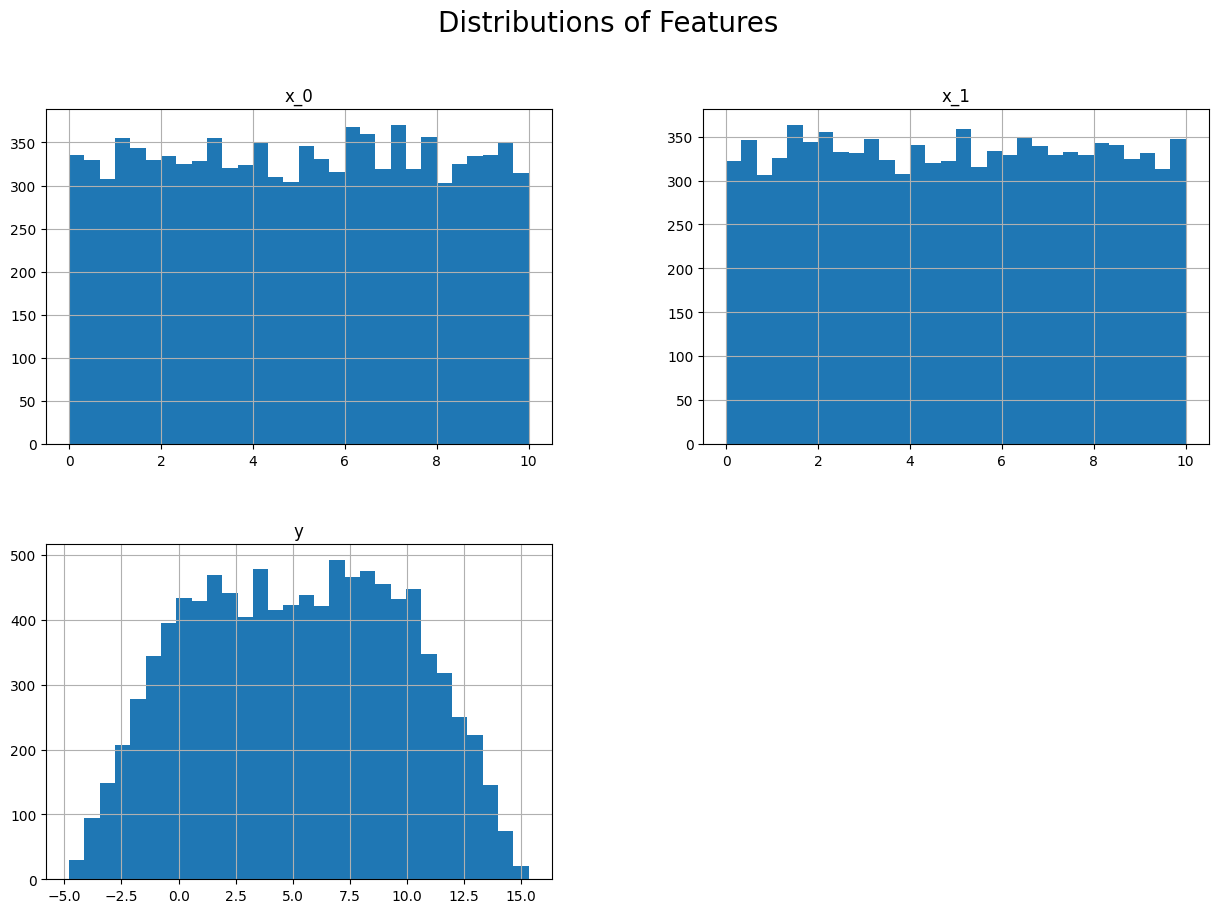

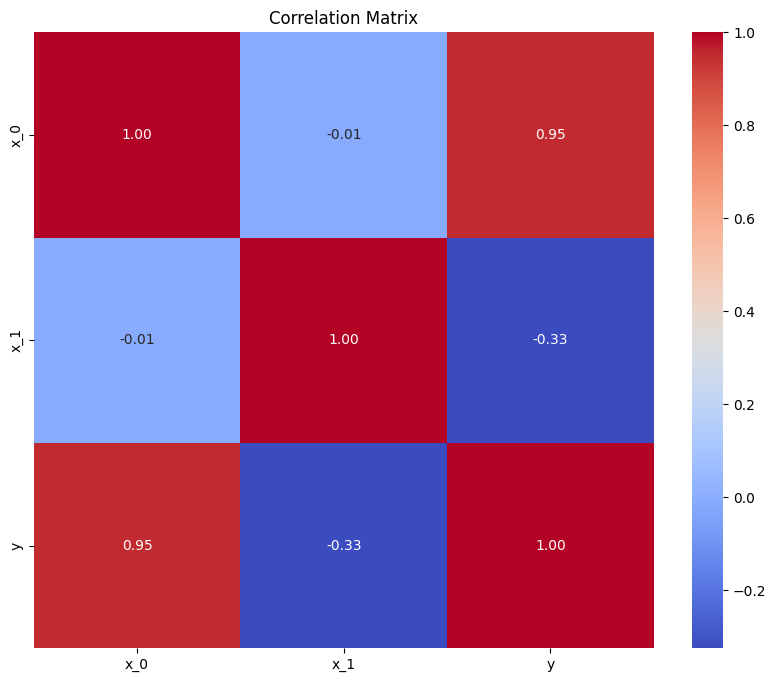


Scatter plots of features against target variable y:


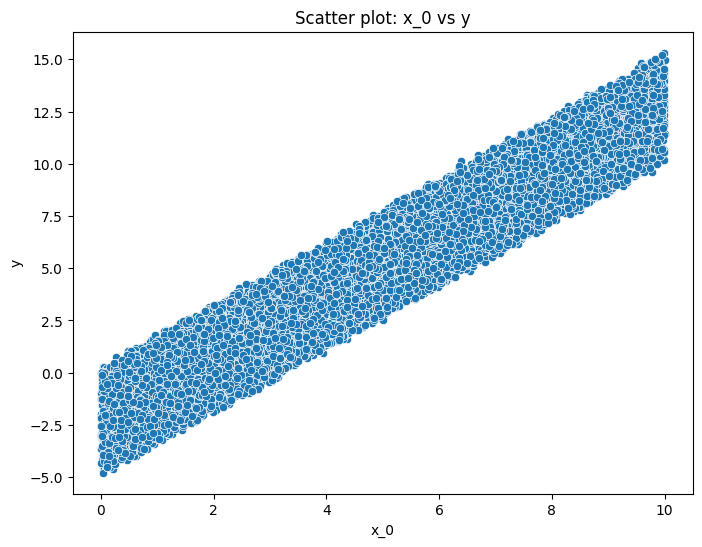

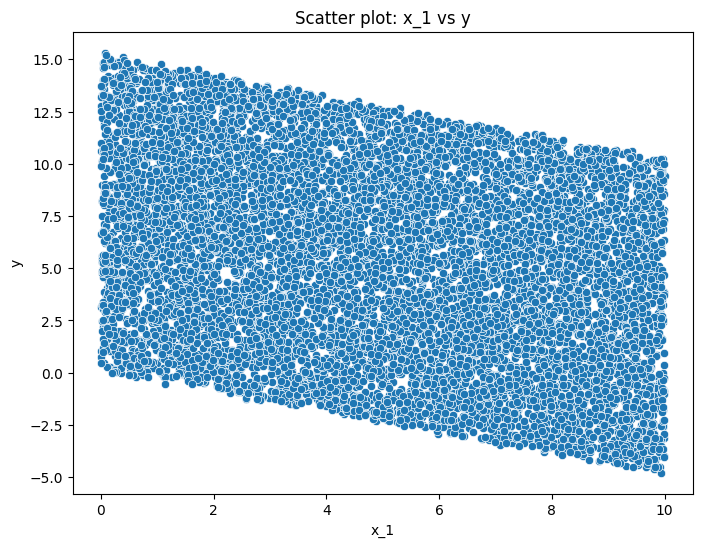

In [4]:
# Display basic information about the dataset
def basic_info(df):
    print("Basic Info:")
    df.info()  # Overview of data types and non-null counts
    print("\nSummary Statistics:")
    print(df.describe())  # Summary statistics for numerical columns

# Check for missing values
def check_missing_values(df):
    print("\nMissing Values:")
    print(df.isnull().sum())  # Count missing values in each column

# Visualize the distribution of each feature
def visualize_distributions(df):
    print("\nDistributions of Features:")
    df.hist(bins=30, figsize=(15, 10))  # Histograms for each feature
    plt.suptitle('Distributions of Features', size=20)
    plt.show()

# Visualize correlation between features
def correlation_matrix(df):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

# Scatter plots for each independent variable against the target
def scatter_plots(df):
    y = df['y']
    features = [col for col in df.columns if col != 'y']
    print("\nScatter plots of features against target variable y:")
    for feature in features:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df[feature], y=y)
        plt.title(f'Scatter plot: {feature} vs y')
        plt.show()

# Main EDA function to call other functions
def perform_eda(df):
    basic_info(df)
    check_missing_values(df)
    visualize_distributions(df)
    correlation_matrix(df)
    scatter_plots(df)

# Perform EDA on the dataset
perform_eda(df)

# Model Defining

In [5]:
class ElasticNetModel:
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=1000, tol=1e-4, epochs=1):
        self.alpha = alpha  # Regularization strength
        self.l1_ratio = l1_ratio  # Balance between L1 and L2 penalties
        self.max_iter = max_iter  # Maximum number of iterations per epoch
        self.tol = tol  # Tolerance for convergence
        self.epochs = epochs  # Number of passes over the dataset
        self.coef_ = None  # Coefficients after training
        self.intercept_ = 0.0  # Intercept

    def _soft_thresholding(self, rho, lambda_):
        """Apply the soft-thresholding operator for L1 penalty."""
        if rho < -lambda_:
            return rho + lambda_
        elif rho > lambda_:
            return rho - lambda_
        else:
            return 0.0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Initialize coefficients
        self.coef_ = np.zeros(n_features)

        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")

            for iteration in range(self.max_iter):
                coef_old = np.copy(self.coef_)

                # Update each coefficient using coordinate descent
                for j in range(n_features):
                    # Compute the residual excluding feature j
                    residual = y - (X @ self.coef_) + self.coef_[j] * X[:, j]
                    rho = X[:, j].T @ residual

                    # Update the j-th coefficient using soft-thresholding
                    weight_update = self._soft_thresholding(rho, self.alpha * self.l1_ratio)
                    self.coef_[j] = weight_update / (X[:, j].T @ X[:, j] + self.alpha * (1 - self.l1_ratio))

                # Check convergence after weight update
                if np.sum(np.abs(self.coef_ - coef_old)) < self.tol:
                    print(f"Convergence reached at iteration {iteration+1}")
                    break

            print(f"Weights after epoch {epoch+1}: {self.coef_}")

        # Calculate intercept as the mean difference between actual and predicted values
        self.intercept_ = np.mean(y - X @ self.coef_)

        return ElasticNetModelResults(self.coef_, self.intercept_)

class ElasticNetModelResults:
    def __init__(self, coef_, intercept_):
        self.coef_ = coef_
        self.intercept_ = intercept_

    def predict(self, X):
        """Make predictions using the learned coefficients."""
        return X @ self.coef_ + self.intercept_

    def evaluate(self, X, y_true):
      """Evaluate the model performance and return MSE and R-squared metrics."""
      y_pred = self.predict(X)
      mse = mean_squared_error(y_true, y_pred)
      r2 = r2_score(y_true, y_pred)
      return mse, r2

def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = np.sum((y_true - y_pred) ** 2) / n
    return mse

def r2_score(y_true, y_pred):
    total_variance = np.sum((y_true - np.mean(y_true)) ** 2)
    explained_variance = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (explained_variance / total_variance)
    return r2

# Fitting the Model

In [6]:
# Extract features (X) and target (y) from the dataframe
X = df[['x_0', 'x_1']].values  # Features
y = df['y'].values  # Target

In [7]:
# Train Test Split
def train_test_split(X, y, test_size=0.2, random_state=None):
    # If a random_state is provided, set the random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)

    # Get the number of samples
    n_samples = X.shape[0]

    # Shuffle the indices
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    # Determine the split point (80% training, 20% testing)
    split_idx = int(n_samples * (1 - test_size))

    # Split the indices into training and testing
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    # Split the data into training and testing sets using the shuffled indices
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

In [8]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Initialize the ElasticNetModel with chosen hyperparameters
model = ElasticNetModel(alpha=0.1, l1_ratio=0.5, max_iter=1000, tol=1e-4, epochs=10)

# Fit the model on the training data
results = model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = results.predict(X_test)

Epoch 1/10
Convergence reached at iteration 16
Weights after epoch 1: [ 1.51731104 -0.48264193]
Epoch 2/10
Convergence reached at iteration 1
Weights after epoch 2: [ 1.51733594 -0.48266061]
Epoch 3/10
Convergence reached at iteration 1
Weights after epoch 3: [ 1.51734983 -0.48267103]
Epoch 4/10
Convergence reached at iteration 1
Weights after epoch 4: [ 1.51735758 -0.48267684]
Epoch 5/10
Convergence reached at iteration 1
Weights after epoch 5: [ 1.51736189 -0.48268008]
Epoch 6/10
Convergence reached at iteration 1
Weights after epoch 6: [ 1.5173643  -0.48268189]
Epoch 7/10
Convergence reached at iteration 1
Weights after epoch 7: [ 1.51736565 -0.48268289]
Epoch 8/10
Convergence reached at iteration 1
Weights after epoch 8: [ 1.5173664  -0.48268345]
Epoch 9/10
Convergence reached at iteration 1
Weights after epoch 9: [ 1.51736681 -0.48268377]
Epoch 10/10
Convergence reached at iteration 1
Weights after epoch 10: [ 1.51736705 -0.48268394]


# Model Testing

In [10]:
# Evaluate the model
mse, r2 = results.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.014483031298381613
R-squared: 0.9992964485023601


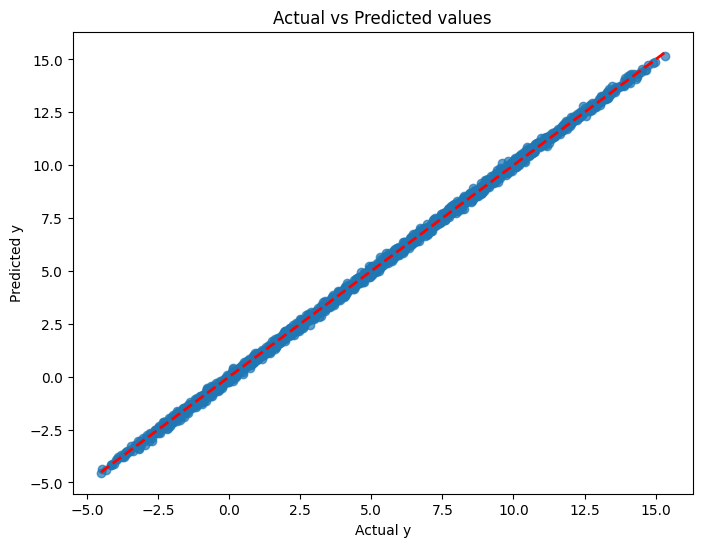

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.title('Actual vs Predicted values')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()

# PyTest

In [12]:
%%writefile elasticnet_model.py
import numpy as np

class ElasticNetModel:
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=1000, tol=1e-4, epochs=1):
        self.alpha = alpha  # Regularization strength
        self.l1_ratio = l1_ratio  # Balance between L1 and L2 penalties
        self.max_iter = max_iter  # Maximum number of iterations per epoch
        self.tol = tol  # Tolerance for convergence
        self.epochs = epochs  # Number of passes over the dataset
        self.coef_ = None  # Coefficients after training
        self.intercept_ = 0.0  # Intercept

    def _soft_thresholding(self, rho, lambda_):
        """Apply the soft-thresholding operator for L1 penalty."""
        if rho < -lambda_:
            return rho + lambda_
        elif rho > lambda_:
            return rho - lambda_
        else:
            return 0.0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Initialize coefficients
        self.coef_ = np.zeros(n_features)

        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")

            for iteration in range(self.max_iter):
                coef_old = np.copy(self.coef_)

                # Update each coefficient using coordinate descent
                for j in range(n_features):
                    # Compute the residual excluding feature j
                    residual = y - (X @ self.coef_) + self.coef_[j] * X[:, j]
                    rho = X[:, j].T @ residual

                    # Update the j-th coefficient using soft-thresholding
                    weight_update = self._soft_thresholding(rho, self.alpha * self.l1_ratio)
                    self.coef_[j] = weight_update / (X[:, j].T @ X[:, j] + self.alpha * (1 - self.l1_ratio))

                # Check convergence after weight update
                if np.sum(np.abs(self.coef_ - coef_old)) < self.tol:
                    print(f"Convergence reached at iteration {iteration+1}")
                    break

            print(f"Weights after epoch {epoch+1}: {self.coef_}")

        # Calculate intercept as the mean difference between actual and predicted values
        self.intercept_ = np.mean(y - X @ self.coef_)

        return ElasticNetModelResults(self.coef_, self.intercept_)

class ElasticNetModelResults:
    def __init__(self, coef_, intercept_):
        self.coef_ = coef_
        self.intercept_ = intercept_

    def predict(self, X):
        """Make predictions using the learned coefficients."""
        return X @ self.coef_ + self.intercept_


Overwriting elasticnet_model.py


In [13]:
%%writefile test_elasticnet.py
import numpy as np
import pytest
from elasticnet_model import ElasticNetModel, ElasticNetModelResults

@pytest.fixture
def example_data():
    # Simple dataset for testing
    X = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
    y = np.array([3, 5, 7, 9])
    return X, y

def test_fit(example_data):
    X, y = example_data

    # Initialize model
    model = ElasticNetModel(alpha=0.1, l1_ratio=0.5, max_iter=1000, tol=1e-4, epochs=1)

    # Fit the model
    results = model.fit(X, y)

    # Check if the coefficients and intercept are non-zero (since it's a simple dataset)
    assert model.coef_ is not None, "Coefficients should not be None after fitting"
    assert model.intercept_ != 0.0, "Intercept should not be zero after fitting"

    # Check if the coefficients are close to expected values (basic linear regression check)
    expected_coef = np.array([1.0, 1.0])  # Roughly expected for this data
    np.testing.assert_almost_equal(model.coef_, expected_coef, decimal=1, err_msg="Coefficients are not as expected")

def test_predict(example_data):
    X, y = example_data

    # Initialize and fit model
    model = ElasticNetModel(alpha=0.1, l1_ratio=0.5, max_iter=1000, tol=1e-4, epochs=1)
    a=model.fit(X, y)

    # Test predict function
    test_data = np.array([[5, 6], [6, 7]])
    predictions = a.predict(test_data)

    # Check if predictions are reasonably close to expected values
    expected_predictions = np.array([11.0, 13.0])  # Based on the trend in the data
    np.testing.assert_almost_equal(predictions, expected_predictions, decimal=1, err_msg="Predictions are not as expected")


Overwriting test_elasticnet.py


In [14]:
!pytest test_elasticnet.py


======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0
rootdir: /content
plugins: anyio-3.7.1, typeguard-4.3.0
collected 2 items                                                                                  

test_elasticnet.py ..                                                                        [100%]

======================================== 2 passed in 0.95s =========================================
